In [445]:
import pandas as pd
pd.options.mode.chained_assignment = None 
#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv('original_dataset.csv', low_memory = False, dtype = {'locality': str, 'postcode': str, 'property_subtype': str})
raw_df = df

In [446]:
df = df[['locality', 'postcode', "property_subtype", "price", "area"]]
regex = "[0-9]{4}"
df = df[df.postcode.str.match(regex, na=False)|df.locality.str.match(regex, na=False)]

In [447]:
#Extraction of useful data from locality field
def extract_address(d): 
    return re.sub("(([A-Za-z0-9àâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})(\d{4})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ'\-\/ \(\)]*)([0-9]{1})|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ&',\.\-\/ \(\)]*))", r'\2',d)
def extract_postcode(d): 
    return re.sub("(([A-Za-z0-9àâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})(\d{4})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ'\-\/ \(\)]*)([0-9]{1})|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ&',\.\-\/ \(\)]*))", r'\4',d)
def extract_locality(d): 
    return re.sub("(([A-Za-z0-9àâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})(\d{4})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ'\-\/ \(\)]*)([0-9]{1})|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ&',\.\-\/ \(\)]*))", r'\5',d)

#df['extracted_address'] = df[~df['locality'].isnull()]['locality'].apply(extract_address)
df['extracted_postcode'] = df[~df['locality'].isnull()]['locality'].apply(extract_postcode)
#df['extracted_locality'] = df[~df['locality'].isnull()]['locality'].apply(extract_locality)

In [448]:
df['merged_postcode'] = df['postcode'].replace(np.nan, '') + df['extracted_postcode'].replace(np.nan, '')
def unmerge_postcode(d): 
    return re.sub("(\d{4}){0,1}(\d{4})$", r'\2', d)
df['unmerged_postcode'] = df[~df['merged_postcode'].isnull()]['merged_postcode'].apply(unmerge_postcode)

In [449]:
regex = '^\d{4}$'
df[~df.unmerged_postcode.str.match(regex, na = False)]

,locality,postcode,property_subtype,price,area,extracted_postcode,merged_postcode,unmerged_postcode
65926,"§S Gravenwezel, Schilde",2970,VILLA,1250000.0,446.0,§,2970§,2970§
66678,Court-Saint-©tienne,1490,HOUSE,399000.0,165.0,©,1490©,1490©


In [450]:
regex = '^\d{4}$'
df = df.drop(df[~df.unmerged_postcode.str.match(regex, na = False)].index)

In [451]:
df = df.drop(['locality', 'postcode', 'extracted_postcode', 'merged_postcode'], axis=1, errors='ignore')

In [452]:
regex = '^(10|11|12)\d{2}$'
df = df.drop(df[~df.unmerged_postcode.str.match(regex, na = False)].index)

In [453]:
df['property_subtype']=np.where(df.property_subtype.str.match('[A-Za-zàâçéèêëîïôûùüÿñæœ]*'),df['property_subtype'].str.upper(),np.nan)

In [454]:
df = df.drop(df[df['price'].isnull()].index)
df = df.drop(df[df['area'].isnull()].index)
df = df.drop(df[df['price'] == 'None'].index)
df = df.drop(df[df['price'] == '@0'].index)
df = df.drop(df[df['area'] == 'None'].index)
df = df.drop(df[df['area'] == 'Not specified'].index)

In [455]:
def clean_price(d): 
    return re.sub("^(€{0,})(([0-9\,\.])+)(€{0,})$", r'\2',d)
df['price'] = df['price'].apply(clean_price)

In [456]:
def clean_weird_price(d): 
    return re.sub("^(([0-9\,\.])+)(€{1} {1})(([0-9\,\.])+)$", r'\1',d)
df['price'] = df['price'].apply(clean_weird_price)

In [457]:
def clean_point(d): 
    return re.sub('^(([0-9])+)([\.]{1})([0]{1})$', r'\1', d)
df['price'] = df['price'].apply(clean_point)

In [458]:
def clean_comma(d): 
    return re.sub('^(([0-9]){0,2})([\,]{0,})(([0-9])+)([\,]{1})(([0-9])+)$', r'\1\3\5', d)
df['price'] = df['price'].apply(clean_comma)

In [459]:
def clean_zero(d): 
    return re.sub('^(([0-9])+)([\,]{1})$', r'\1000', d)
df['price'] = df['price'].apply(clean_zero)

In [460]:
def clean_million(d): 
    return re.sub('^(([0-9]){1})([\,]{1})(([0-9]){1})$', r'\1\300000', d)
df['price'] = df['price'].apply(clean_million)

In [461]:
def clean_area(d): 
    return re.sub('^([0-9]+)( {0,}m{0,}²{0,})', r'\1',d)
df['area'] = df['area'].apply(clean_area)

In [462]:
df = df.drop(df[df['price'] == '1À000'].index)
df = df.drop(df[df['price'] == '2À000'].index)
df = df.drop(df[df['price'] == '3À000'].index)

In [463]:
df = df.drop(df[df['price'] == '23456789'].index)

In [464]:
df['price'] = pd.to_numeric(df['price'])
df['area'] = pd.to_numeric(df['area'])

In [465]:
df = df.drop(df[df['area']>600].index)

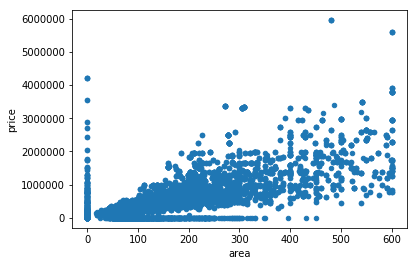

In [466]:
df.plot.scatter(x = 'area', y = 'price')

In [467]:
df

,property_subtype,price,area,unmerged_postcode
3,HOUSE,545000,235.0,1200
4,MIXED_USE_BUILDING,500000,220.0,1190
7,APARTMENT_BLOCK,650000,200.0,1150
11,APARTMENT_BLOCK,399000,137.0,1030
14,APARTMENT_BLOCK,1750000,550.0,1200
19,APARTMENT_BLOCK,695000,257.0,1140
24,MIXED_USE_BUILDING,1395000,568.0,1000
29,APARTMENT_BLOCK,520000,360.0,1030
30,APARTMENT_BLOCK,749000,350.0,1090
31,APARTMENT_BLOCK,2300000,500.0,1050
